# Variational Quantum Deflation (VQD) Algorithm 

This notebook demostrates how to use Qiskit's implementation of the [Variational Quantum Deflation (VQD)](https://qiskit.org/documentation/stubs/qiskit.algorithms.eigensolvers.VQD.html) algorithm for computing higher energy states of a Hamiltonian, as introduced in this [reference paper](https://arxiv.org/abs/1805.08138). 

## Introduction

`VQD` is a quantum algorithm that uses a variational technique to find the `k` eigenvalues of the Hamiltonian `H` of a given system.
    
The algorithm computes excited state energies of generalised hamiltonians by optimising over a modified cost function, where each succesive eigenvalue is calculated iteratively by introducing an overlap term with all the previously computed eigenstates that must be minimised. This ensures that higher energy eigenstates are found.

## Complete working example for VQD

As a first sep for this example, we will create a qubit operator, ansatz and optimizer. In this case, we will use the previously employed H2 molecule, but in addition of the ground state already known from the `VQE` tutorials, we will now also compute 2 excited states (so, in total, `k=3`).

In [1]:
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

The ansatz will be a `TwoLocal` anstaz with 3 qubits, and the optimization method will be `SLSQP`.

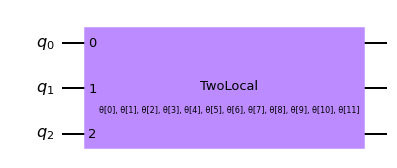

In [2]:
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SLSQP

num_qubits = 2
ansatz = TwoLocal(3, rotation_blocks=["ry", "rz"], entanglement_blocks="cz", reps=1)

optimizer = SLSQP()
ansatz.draw('mpl')

Next, we define the required primitives for running `VQD`. This algorihtm requires 2 different primitive instances: one `Estimator` for computing the expectation values for the "VQE part" of the algorithm, and one `Sampler` passed along to the `StateFidelity` subroutine that will be used to compute the cost for higher energy states. In this example, we will use the `ComputeUncompute` fidelity method for this cost computation.

In [3]:
from qiskit.primitives import Sampler, Estimator
from qiskit.algorithms.state_fidelities import ComputeUncompute

estimator = Estimator()
sampler = Sampler()
fidelity = ComputeUncompute(sampler)

In order to set up the VQD algorithm, it is important to define two additional inputs: the number of states to compute (`k`) and the `betas` defined in the original VQD paper. These `betas` balance the contribution of each overlap term to the cost function. In this example, we are going to set up the following values:

In [4]:
k = 3
betas = [50, 50, 50]

Finally, we can run our VQD algorithm, but let's define a callback first to store intermediate values:

In [5]:
counts = []
values = []
steps = []

def callback(eval_count, params, value, meta, step):
    counts.append(eval_count)
    values.append(value)
    steps.append(step)

In [6]:
from qiskit.algorithms.eigensolvers import VQD

vqd = VQD(estimator, fidelity, ansatz, optimizer, k=k, betas=betas, callback=callback)
result = vqd.compute_eigenvalues(operator = H2_op)

We can see our 3 state energies as part of the VQD result:

In [7]:
print(result.optimal_values)

[-1.8572746  -1.24458464 -0.88272226]


And we can use the values stored by the callback to plot the energy convergence for each state:

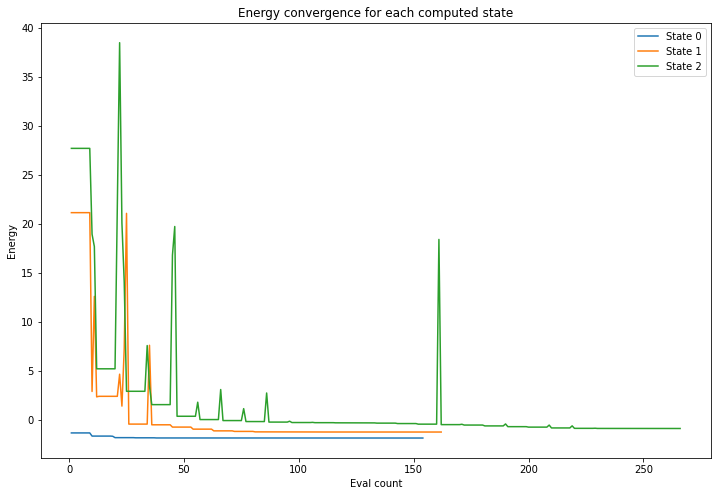

In [8]:
import numpy as np
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)

steps = np.asarray(steps)
counts = np.asarray(counts)
values = np.asarray(values)

for i in range(1,4):
    _counts = counts[np.where(steps == i)]
    _values = values[np.where(steps == i)]
    pylab.plot(_counts, _values, label=f"State {i-1}")
    
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for each computed state")
pylab.legend(loc="upper right");

In [9]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright